### Alunos
- Alexandre Candido Souza
- Klarissa Andrade de Morais

# Introdução

In [449]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import silhouette_score



plt.style.use('default')

trainData = pd.read_csv('./input/titanic_unsupervised.csv',index_col=0)


Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [450]:
print("Training DataSet:")
print(trainData.isna().sum())

Training DataSet:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


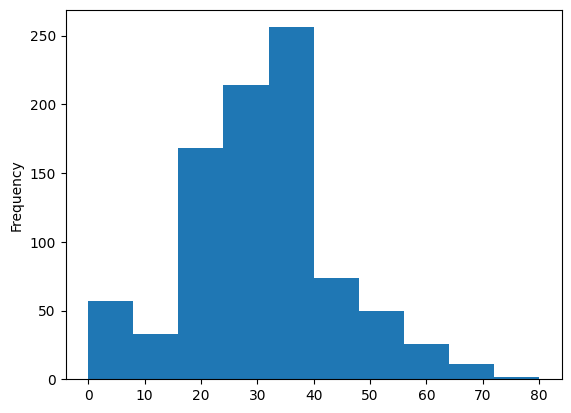

In [451]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [452]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
trainData = trainData.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1)
trainData.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,1.198020,0.470297,35.254141,0.445545,0.440594,76.103301,1.297030
std,0.528205,0.500357,14.955741,0.630490,0.732294,74.759941,0.946789
min,1.000000,0.000000,0.920000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.000000,0.000000,0.000000,28.959375,0.000000
50%,1.000000,0.000000,33.500000,0.000000,0.000000,55.000000,2.000000
75%,1.000000,1.000000,46.750000,1.000000,1.000000,89.776050,2.000000
max,3.000000,1.000000,80.000000,3.000000,4.000000,512.329200,2.000000


Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
O dado mais relevante é saber se o passageiro está sozinho ou não. Por isso só ele é mantido

In [453]:
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch"], axis=1)

## Visualizando a Distribuição dos Dados
Após todos os processos de tratamento, temos os parametros finais a ser utilizado pelo algoritmo. Agora, iremos visualizar brevemente a nova distribuição dos dados de custo que foram mapeados:

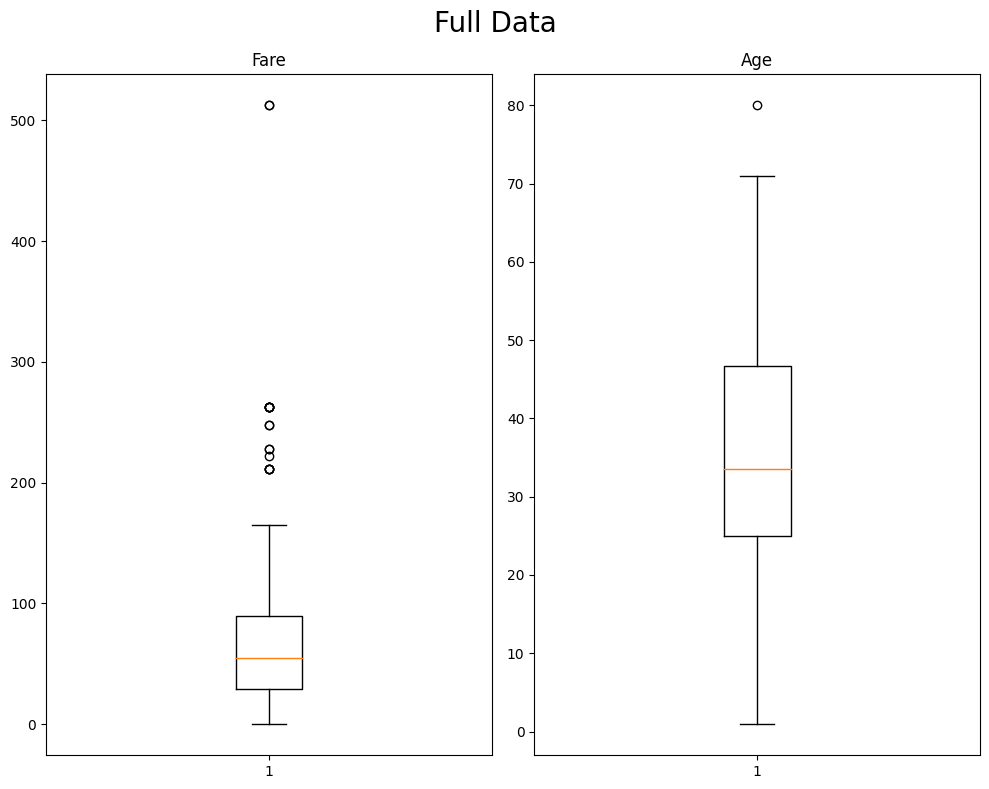

In [454]:
params = ["Fare", "Age"]
count = len(params)
width = 2
height = int(count/width)
figure, axis = plt.subplots(height, width, figsize=(10, 8))
figure.suptitle("Full Data", fontsize=20)

for i,attr in enumerate(params):
    values = trainData[attr].astype(float)
    axis[i].boxplot(values)
    axis[i].set_title(attr)

plt.tight_layout()
plt.show()

Percebemos que existem valores bem distantes no atributo "Fare". Como estão em pouquissima quantidade, nós resolvemos remover-los para manter a consistência

In [455]:
trainData = trainData.drop(trainData[trainData["Fare"] > 200].index)

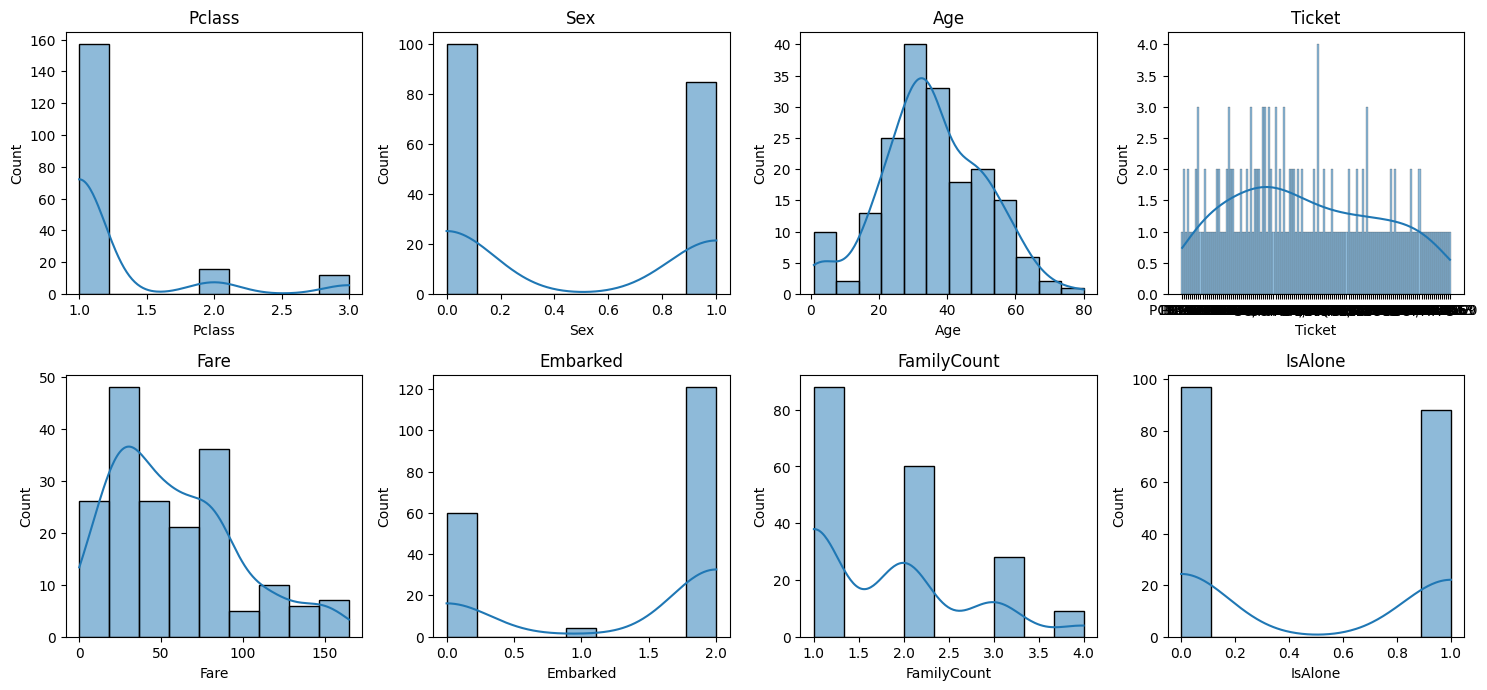

In [456]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(trainData.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(trainData[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


## Normalizando os dados
Normalizamos os dados do conjunto de dados para garantir que os algoritmos de clusterização, que dependem fortemente da distância entre os centroides, não sejam distorcidos por valores extremos. Ao transformar as características em uma escala comum, cada uma contribui igualmente para a distância entre os centroides, assegurando uma análise mais equilibrada e precisa.

In [457]:
trainData = pd.DataFrame(normalize(trainData, axis=0), columns=trainData.columns)
trainData.head()

ValueError: could not convert string to float: 'PC 17599'

## Escolhendo a quantidade de Clusters

Quando realizamos análise de cluster, uma etapa crítica é determinar o número apropriado de clusters em que os dados devem ser divididos.  


O método Elbow procura encontrar um equilíbrio entre a máxima compactação interna dos clusters e a mínima quantidade de clusters, identificando um ponto onde adicionar mais clusters não resulta em um ganho significativo na inércia, que é a soma das distâncias ao quadrado das amostras para o centro do cluster mais próximo. Por outro lado, o índice Silhouette avalia a qualidade dos clusters medindo o quão semelhante um objeto é ao seu próprio cluster em comparação a outros clusters. Usar ambos os métodos pode dar uma visão mais completa e possibilitar uma decisão mais informada sobre o número de clusters a serem utilizados na análise.

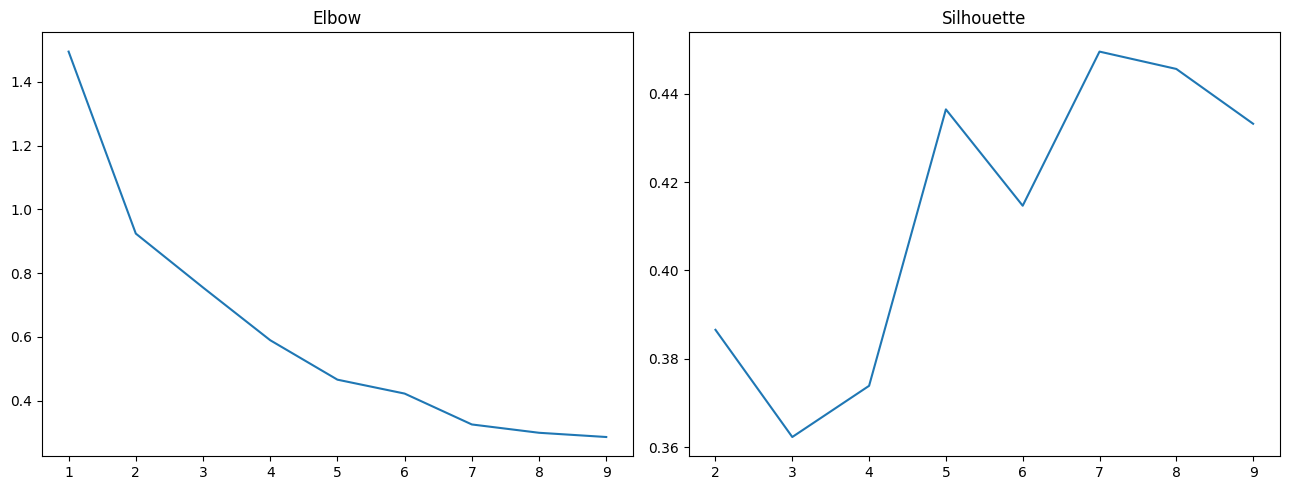

In [ ]:

k_range = list(range(1, 10))
scores = {"elbow": [], "silhouette": []}

for i in k_range:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(trainData)
    scores["elbow"].append([i, kmeans.inertia_])
    if i == 1: continue
    scores["silhouette"].append([i, silhouette_score(trainData, kmeans.labels_)])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for i, (score_name, score_data) in enumerate(scores.items()):
    score_data = np.array(score_data)
    axes[i].plot(score_data[:, 0], score_data[:, 1])
    axes[i].set_title(score_name.capitalize())

plt.tight_layout()
plt.show()


Levando em consideração ambos os métodos, parece que não há um ponto óbvio e claro para o número de clusters. O método do elbow mostra uma possível escolha em k=3, enquanto o índice Silhouette sugere que a qualidade dos clusters melhora à medida que se aumenta o número de clusters, chegando até k=10. No entanto, escolher um valor de k muito alto pode não ser prático ou interpretável no contexto dos dados.

Uma abordagem sensata seria escolher um valor de k que seja grande o suficiente para capturar a estrutura dos dados, mas ainda pequeno o suficiente para ser interpretável e significativo. Com base no índice Silhouette, podemos optar por um valor intermediário como k=6, que mostra um bom equilíbrio entre a qualidade dos clusters e a parcimônia do modelo. Isso também evita a complexidade desnecessária que viria com a escolha do número máximo avaliado de k=10

## K-Means

O K-means é um popular algoritmo de aprendizado de máquina para clusterização que agrupa os dados em K número de clusters. O objetivo é minimizar a variação dentro de cada cluster e maximizar a variação entre clusters. Cada cluster no K-means é representado pelo seu centroide, que é a média de todos os pontos atribuídos ao cluster.

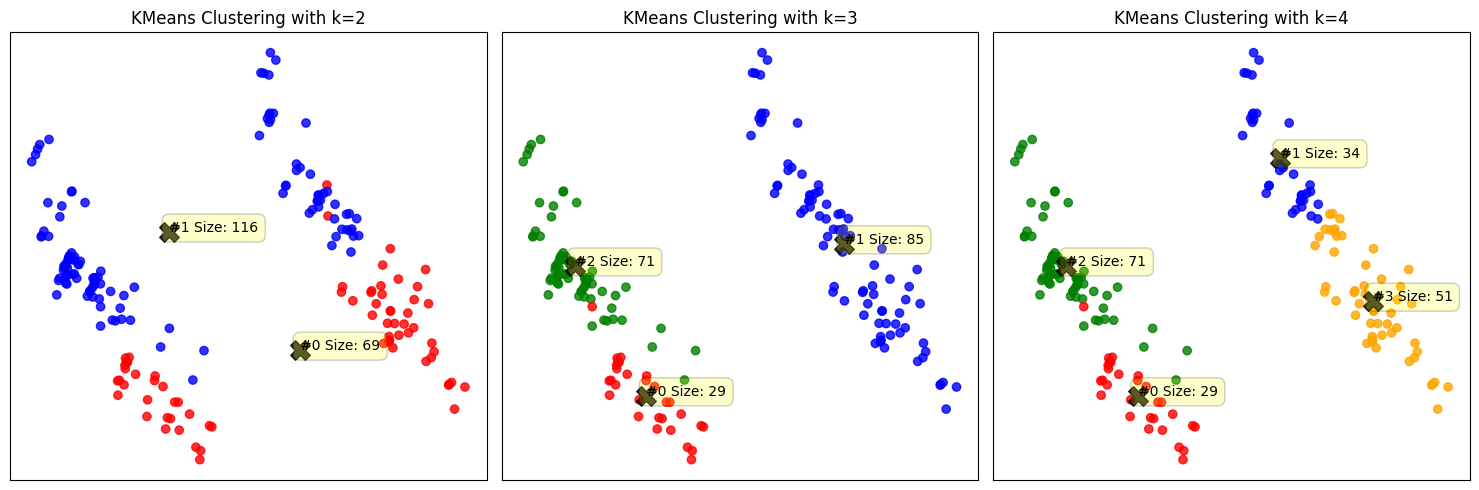

In [ ]:
k_values = [2, 3, 4]
k_colors = ['red', 'blue', 'green', 'orange', 'pink', 'purple', 'brown'];

# Determine the number of rows and columns based on the length of k_values
num_cols = min(len(k_values), 3)
num_rows = (len(k_values) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
colors = np.array(k_colors)

for i, k in enumerate(k_values):
    row = i // num_cols
    col = i % num_cols
    
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(trainData)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(trainData.values)

    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans.labels_], alpha=0.8)
    ax.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
               c='black', s=200, alpha=0.8, marker='X')
    ax.set_title(f'KMeans Clustering with k={k}')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    cluster_sizes = [np.sum(kmeans.labels_ == j) for j in range(k)]    
    # Annotate cluster sizes
    for cluster_id, cluster_center in enumerate(pca.transform(kmeans.cluster_centers_)):
        ax.annotate(
            f'#{cluster_id} Size: {cluster_sizes[cluster_id]}',
            xy=(cluster_center[0], cluster_center[1]),
            xycoords='data',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2)
        )



# Hide any empty subplots
for i in range(len(k_values), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Neste gráfico, exploramos a aplicação do algoritmo K-means em diferentes números de clusters (k). 

Utilizamos uma análise de componentes principais (PCA) para reduzir a dimensionalidade dos dados para visualização em duas dimensões.Cada subplot representa um número diferente de clusters (k), variando de 2 a 7.

Esta visualização nos ajuda a entender como a escolha do número de clusters afeta a estrutura dos grupos identificados pelo algoritmo K-means, fornecendo insights valiosos sobre a estrutura subjacente dos nossos dados e potencialmente auxiliando em futuras análises e tomadas de decisão.

## Analisando cada Cluster

Com os gráficos ácima podemos ver como os clusters estão distribuidos. Mas também é interessante analisar o que caracteristica cada cluster. Podemos exibir as médias de cada valor assim:

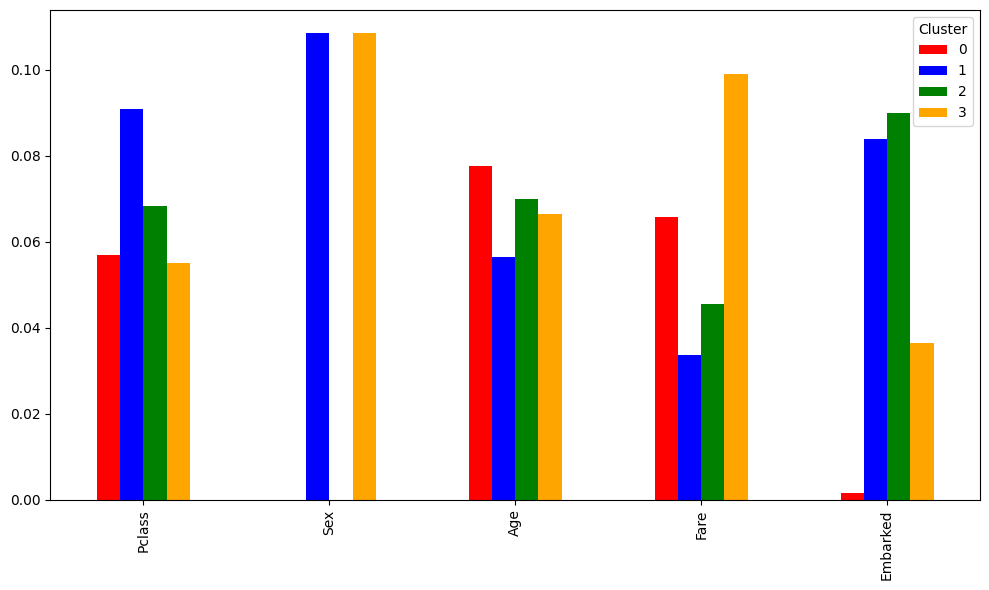

In [ ]:
# Atribuir os rótulos dos clusters aos dados
trainData['Cluster'] = kmeans.labels_

# Calcular as médias de cada variável por cluster
cluster_means = trainData.groupby('Cluster').mean()
cluster_means_transposed = cluster_means.T

fig, ax = plt.subplots(figsize=(10, 6))
cluster_means_transposed.plot(kind='bar',ax=ax, color=colors)

plt.tight_layout()
plt.show()